<a id='home'></a>
### purpose

explore differences in R2 from loci used by GF_geno models but not GF_AF models

### outline

1. [load metadata](#meta)
1. [load loci with positive R2 from GF models](#loci)
1. [compare R2 among marker types](#comp)
    1. Boxplots
        1. [polygenicity x marker set x landscape, nested in AF or geno models](#fig1)
        1. [marker set x polygenicity, nested in AF or geno models](#fig2)
        1. [marker set x landscape, nested in AF or geno models](#fig3)
    1. Histograms
        1. [marker set x polygenicity, nested in AF or geno](#fig4)
        1. [marker set x landscape, nested in AF or geno](#fig5)
        1. [marker set x number of training loci, nested in AF or geno](#fig6)
1. [compare R2 between loci specific to GF$_{geno}$ with overlap between GF$_{geno}$ and GF$_{AF}$](#comp5)
    1. [compare, no subcategories (boxplot)](#nocat)
    1. [compare by parameters (boxplots)](#parameter)
1. [for overlap loci, what is difference in R2 between workflows?](#comp6)

    compare the magnitude of R2 between loci in both GF$_{AF}$ and GF$_{geno}$ models

In [1]:
from pythonimports import *
import myfigs as mf

import runtime_API as rt
import MVP_summary_functions as mvp

import seaborn as sns
import itertools as it

lview, dview = get_client(cluster_id='1727466774-iwy1', profile='lotterhos')

figdir = makedir(f'{rt.resdir}/figures/05_supplemental/05_explore_r2_geno_ind_loci')

t0 = dt.now()

rt.latest_commit()
session_info.show()

36 36
#########################################################
Today:	September 27, 2024 - 15:54:25 EDT
python version: 3.8.5
conda env: mvp_env

Current commit of pythonimports:
commit 6a767410e7b569adbf9df526de108f22ef50aad8  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Wed Mar 6 13:42:13 2024 -0700

Current commit of MVP_offsets:
commit 5ce82f4d655645237a0f4026fa32e220226dc373  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Thu May 16 13:02:58 2024 -0400

Current commit of MVP_runtime:
commit df87dd2c708ac0fdeebcfaaca239473ca2c487af  
Author: Brandon Lind <lind.brandon.m@gmail.com>  
Date:   Tue Mar 19 16:17:46 2024 -0400
#########################################################



<a id='meta'></a>
# load metadata

[top](#home)

In [2]:
params = mvp.read_params_file()

params.head(1)

100%|███████████████| 2250/2250 [00:02<00:00, 782.03it/s]


,level,reps,arch,demog_name,demog_level_sub,demog_level,MIG_x,MIG_y,xcline,ycline,demog,METAPOP_SIDE_x,METAPOP_SIDE_y,Nequal,isVariableM,MIG_breaks,arch_level_sub,arch_level,MU_base,MU_QTL_proportion,SIGMA_QTN_1,SIGMA_QTN_2,SIGMA_K_1,SIGMA_K_2,N_traits,ispleiotropy,seed,final_LA,glevel,plevel,pleio,slevel,landscape,popsize,migration,landscape-slevel
1231094,highly-polygenic_1-trait__Est-Clines_N-cline-c...,1,highly-polygenic_1-trait,Est-Clines_N-cline-center-to-edge_m-constant,N-cline-center-to-edge_m-constant,Est-Clines,0.49,0.07,linear,linear,Estuary,10,10,4,0,0,1-trait,highly-polygenic,1.000000e-07,0.25,0.002,0.002,0.5,0.5,1,0,1231094,0.500854,highly-polygenic,1-trait,no pleiotropy,NaN,Est-Clines,N-cline-center-to-edge,m-constant,Est-Clines_1-trait


<a id='loci'></a>
# load loci with positive R2 from GF models

[top](#home)

In [3]:
def annotate_outfile(outfile, source, rep, num_loci):
    """Get a set of loci, and annotate with regard to marker type and simulation info."""
    import MVP_01_train_gradient_forests as mvp01
    import MVP_summary_functions as mvp
    
    import pandas as pd
    from os import path as op
    
    seed = op.basename(outfile).split("_")[0]
    
    # read in dataframe, annotate
    df = pd.read_table(outfile).reset_index(drop=False)
    df.columns = ['locus', 'R2']
    df['source'] = source
    df['rep'] = rep
    df['num_loci'] = num_loci
    df['seed'] = seed
    df.index = df['locus']
#     dfs.append(df)
    
    # annotate loci whether adaptive, neutral-linked, or neutral
    mvp01.seed = seed
    mvp01.slimdir = mvp.slimdir
    muts = mvp01.read_muts_file()
    
    marker_type = {
        'adaptive' : muts.index[muts.causal == True].tolist(),
        'neutral' : muts.index[(muts.causal == False) & (muts.LG > 10)].tolist(),
        'neutral-linked' : muts.index[(muts.causal == False) & (muts.LG <= 10)].tolist()
    }
    
    df['marker_type'] = "None"
    for marker_group, markers in marker_type.items():
        df.loc[df.locus.isin(markers), 'marker_type'] = marker_group

    df.index = df['locus'] + '_' + '_'.join(map(str, [source, num_loci, seed]))
    
    return df

In [4]:
# in parallel, retrieve/annotate outfiles containing loci and R2 values used by GF models (rsq > 0)
jobs = []
for (source, rep), repdirs in unwrap_dictionary(rt.dirs):
    for repdir in pbar(repdirs, desc=f'{source} {rep}'):
        num_loci = op.basename(repdir)  #.lstrip('0')
        
        outdir = f'{repdir}/gradient_forests/get_loci_pos_rsq/outfiles'

        outfiles = fs(outdir, endswith='.txt')

        for outfile in outfiles:
            jobs.append(
                lview.apply_async(
                    annotate_outfile, *(outfile, source, rep, num_loci)
                )
            )

# wait for jobs to be done
watch_async(jobs)

# collect completed jobs
rsq_data = pd.concat([j.r for j in jobs])
rsq_data.index.name = None

# annotate a bit more
for param in pbar(rt.hue_order.keys(), desc='annotating params'):
    if param in ['model', 'source', 'noncausal_env', 'marker_set', 'program', 'num_loci', 'demography', 'final_la_bin']:
        continue
    rsq_data[param] = rsq_data.seed.map(params[param])
    
assert nrow(rsq_data) == rsq_data.index.unique().__len__()

rsq_data.head()

pooled run_20220919_450-675: 100%|███████████████| 4/4 [00:00<00:00,  4.12it/s]



Watching 4051 jobs ...


annotating params: 100%|███████████████| 14/14 [00:09<00:00,  1.53it/s]


,locus,R2,source,rep,num_loci,seed,marker_type,landscape,glevel,pleio,slevel,popsize,migration
15-718088_ind_00500_1231109,15-718088,0.106075,ind,run_20220919_0-225,00500,1231109,neutral,Est-Clines,highly-polygenic,no pleiotropy,equal-S,N-cline-center-to-edge,m-constant
14-650308_ind_00500_1231109,14-650308,0.144646,ind,run_20220919_0-225,00500,1231109,neutral,Est-Clines,highly-polygenic,no pleiotropy,equal-S,N-cline-center-to-edge,m-constant
16-783804_ind_00500_1231109,16-783804,0.007530,ind,run_20220919_0-225,00500,1231109,neutral,Est-Clines,highly-polygenic,no pleiotropy,equal-S,N-cline-center-to-edge,m-constant
12-563411_ind_00500_1231109,12-563411,0.146321,ind,run_20220919_0-225,00500,1231109,neutral,Est-Clines,highly-polygenic,no pleiotropy,equal-S,N-cline-center-to-edge,m-constant
12-577296_ind_00500_1231109,12-577296,0.024588,ind,run_20220919_0-225,00500,1231109,neutral,Est-Clines,highly-polygenic,no pleiotropy,equal-S,N-cline-center-to-edge,m-constant


In [5]:
rsq_data.shape  # 26654087

(26654087, 13)

In [6]:
rsq_data.num_loci.str.zfill(5).unique()

array(['00500', '05000', '10000', '20000'], dtype=object)

In [7]:
rsq_data.marker_type.value_counts()

# neutral-linked    13233605
# neutral           13196369
# adaptive            224113

neutral-linked    13233605
neutral           13196369
adaptive            224113
Name: marker_type, dtype: int64

In [8]:
# determine which loci were used only by ind-level models

# get nested sets of loci with r2 > 0 (created in 04_check_overlap_of_loci.ipynb)
    # this data is just rownames of tables read in from `outdir` above
pkl = '/work/lotterhos/brandon/runtime/figures/05_supplemental/04_check_overlap_of_loci/loci.pkl'
loci = pklload(pkl)

# get non-intersecting sets of loci
non_overlap = []
overlap_loci = []
for (rep, num_loci, seed), ind_loci in unwrap_dictionary(loci['ind'], progress_bar=True):
    
    pool_loci = loci['pooled'][rep][num_loci][seed]
    
    ind_loci_unique = list(set(ind_loci) - set(pool_loci))
    
    # overlap loci
    overlaps = list(set(ind_loci).intersection(pool_loci))
    overlap_loci.extend(
        [f'{locus}_ind_{num_loci}_{seed}' for locus in overlaps]
    )
    overlap_loci.extend(
        [f'{locus}_pooled_{num_loci}_{seed}' for locus in overlaps]
    )
    
    _ = []
    for locus in ind_loci_unique:
        _.append(f'{locus}_ind_{num_loci}_{seed}')
        
    non_overlap.extend(_)
    
assert luni(non_overlap) == len(non_overlap)

# annotate rsq_data
rsq_data['ind_unique'] = False
rsq_data.loc[non_overlap, 'ind_unique'] = True
rsq_data['overlap_loci'] = False
rsq_data.loc[overlap_loci, 'overlap_loci'] = True

rsq_data.ind_unique.sum()  # should be 3215002, which is the sum from the venn diagrams created in 04.ipynb
                            # 114697 + 3073136 + 27169

100%|███████████████| 3/3 [00:07<00:00,  2.42s/it]


3215002

In [9]:
len(non_overlap)

3215002

<a id='comp'></a>
# compare R2 among marker types

[top](#home)

In [10]:
# from a newer version of pythonimports
def stacked_histo_box(data, x=None, y=None, height_ratios=(0.15, 0.85), figsize=(9, 6), ax=None,
                      box_linewidth=1.5, boxplot_kws={}, hist_bins=None, histplot_kws={}, **kwargs):
    """Create stacked histogram with multi-category boxplot in top margin.
    
    Parameters
    ----------
    data : pd.DataFrame.astype({x : float | int, y : str | object})
        dataframe with columns `x` and `y`, where `y` is the categories used for plotting
    height_ratios : tuple
        height (y-axis) ratios of boxplot and histogram
    figsize : tuple
        figure size
    ax : None | matplotlib.axes.Axes | matplotlib.axes._subplots.AxesSubplot
        axis for plotting
    box_linewidth : float
        edge width of boxplot, median line, whiskers, and caps
    boxplot_kws : dict
        passed to seaborn.boxplot
    histplot_kws : dict
        passed to AxesSubplot.hist
    kwargs : dict
        passed to plt.subplots
    
    Returns
    -------
    (ax_box, ax_hist)
        AxesSubplot's for histogram and 
    """
    from mpl_toolkits.axes_grid1 import make_axes_locatable  # update for notebook

    # update default boxplot kwargs
    default_boxplot_kws = {'whiskerprops': {'color': '#bebebe', 'linewidth' : box_linewidth},
                           'medianprops': {'color': '#bebebe', 'alpha': 1.0, 'linewidth' : box_linewidth},
                           'boxprops': {'edgecolor': '#bebebe', 'linewidth' : box_linewidth},
                           'flierprops': {'color': '#bebebe',
                                          'markeredgecolor': '#bebebe',
                                          'markerfacecolor': 'none',
                                          'markeredgewidth': 0.5,
                                          'markersize': 4,
                                          'marker': '.'},
                           'capprops': {'color': '#bebebe', 'linewidth' : box_linewidth}}
    default_boxplot_kws.update(boxplot_kws)
    if 'palette' not in default_boxplot_kws.keys():  # add a color palette to differentiate categories of `y`
        default_boxplot_kws.update({'palette' : dict(zip(data[y].dropna().unique(), plt.cm.tab20.colors))})

    # update default histplot kwargs
    default_histplot_kws = {'edgecolor' : 'k'}
    default_histplot_kws.update(histplot_kws)

    # create a figure composed of two axes (ax_box and ax_hist)
    if ax is None:
        fig, (ax_box, ax_hist) = plt.subplots(2, sharex=True, figsize=figsize,
                                              gridspec_kw={"height_ratios": height_ratios}, **kwargs)
    else:
        ax_hist = ax
        divider = make_axes_locatable(ax_hist)
        ax_box = divider.append_axes("top", size="15%", pad=0.1, sharex=ax_hist)

    # create boxplot
    sns.boxplot(
        data=data,
        x=x,
        y=y,
#         hue=y,
        ax=ax_box,
#         legend=False,
        **default_boxplot_kws
    )

    # adjust boxplot properties
    ax_box.set_yticks(ax_box.get_yticks())
    ax_box.set_yticklabels([None] * len(data[y].dropna().unique()))
    mf.jitter_fliers(axes=[ax_box], jitter_axis='y', jit=0.15)  # update for notebook - specify mf.
    ax_box.set_ylabel(None)
    ax_box.set_xlabel(None)
    if ax is not None:
        # Remove xlabel and xticks from the boxplot
        xticklabels = ax_hist.get_xticklabels()
        ax_box.tick_params(labelbottom=False)
        ax_box.set_xlabel(None)

    # create stacked histogram
    histdata = data.groupby(y)[x].apply(pd.DataFrame)
    ax_hist.hist(
        histdata,
        stacked=True,
        color=histdata.columns.map(default_boxplot_kws['palette']),
        **default_histplot_kws,
    )

    # add color dict to axes so I can access it without returning another variable
    ax_box.__dict__['palette'] = default_boxplot_kws['palette']
    ax_hist.__dict__['palette'] = default_boxplot_kws['palette']
    
    return ax_box, ax_hist


def add_legend(ldict, markers='s', legendmarkerfacecolor='fill', markeredgecolor=None, title=None, ax=None,
               loc='center left', bbox_to_anchor=(0.95, 0.50), fontsize=11, ncol=1, add_handles=[],
               face_alpha=1, edge_alpha=1
              ):
    """Add a legend to `ax`.

    Parameters
    ----------
    ldict : dict
        key = value = label used in legend labels, value = color
    markers : dict | str
        if dict, use keys in ldict. If str, specify marker for all ldict.keys()
    legendmarkerfacecolor : 'fill' | str | tuple(R, G, B, [alpha])
        if 'fill', use color in ldict. Otherwise, specify another color. use with `face_alpha`.
    markeredgecolor : str | dict
        use with `edge_alpha`. if dict, keys are ldict.keys()
    title : str
        title for legend
    ax : e.g., matplotlib.axes._axes.Axes | cartopy.mpl.geoaxes.GeoAxes
    loc : str
        location of legend with respect to bbox_to_anchor location
    bbox_to_anchor : tuple
        Box that is used to position the legend in conjunction with *loc*.
    fontsize : int
        fontsize of legend. legend title is fontsize+1
    ncol : int
        the number of columns in the legend
    face_alpha : int | dict
        opacity of facecolor. if dict, keys are ldict.keys()
    edge_alpha : int | dict
        opacity of edgecolor. if dict, keys are ldict.keys()
    """
    from matplotlib.colors import colorConverter  # update for notebook
    import matplotlib.lines as mlines  # update for notebook
    
    if ax is None:
        fig, ax = plt.subplots()
    else:
        fig = ax.get_figure()

    # get the things that go into the legend
    handles = []
    for label, color in ldict.items():
        marker = markers[label] if isinstance(markers, dict) else markers
        facealpha = face_alpha[label] if isinstance(face_alpha, dict) else face_alpha
        edgealpha = edge_alpha[label] if isinstance(edge_alpha, dict) else edge_alpha

        if legendmarkerfacecolor == 'fill':
            markerfacecolor = (*colorConverter.to_rgb(color), facealpha)
        else:
            markerfacecolor = (*colorConverter.to_rgb(legendmarkerfacecolor), facealpha)

        if markeredgecolor is None:
            medgecolor = (*colorConverter.to_rgb(color), edgealpha)
        elif isinstance(markeredgecolor, dict):
            medgecolor = (*colorConverter.to_rgb(markeredgecolor[label]), edgealpha)
        else:
            medgecolor = markeredgecolor

        handles.append(
            mlines.Line2D([0], [0], marker=marker, color='none', markerfacecolor=markerfacecolor,
                   markeredgecolor=medgecolor,
                   label=label, markersize=fontsize)
        )
    handles.extend(add_handles)

    # create a legend
    leg1 = fig.legend(
        handles=handles, fancybox=True, shadow=False, ncol=ncol, title=title,
        facecolor='whitesmoke', loc=loc, bbox_to_anchor=bbox_to_anchor,
        prop=dict(family='serif', size=fontsize)
    )
    fig.add_artist(leg1)
    plt.setp(leg1.get_title(), family='serif', fontsize=fontsize+1)
    leg1.get_title().set_multialignment('center')

    pass

In [11]:
rsq_data.head()

,locus,R2,source,rep,num_loci,seed,marker_type,landscape,glevel,pleio,slevel,popsize,migration,ind_unique,overlap_loci
15-718088_ind_00500_1231109,15-718088,0.106075,ind,run_20220919_0-225,00500,1231109,neutral,Est-Clines,highly-polygenic,no pleiotropy,equal-S,N-cline-center-to-edge,m-constant,False,True
14-650308_ind_00500_1231109,14-650308,0.144646,ind,run_20220919_0-225,00500,1231109,neutral,Est-Clines,highly-polygenic,no pleiotropy,equal-S,N-cline-center-to-edge,m-constant,False,True
16-783804_ind_00500_1231109,16-783804,0.007530,ind,run_20220919_0-225,00500,1231109,neutral,Est-Clines,highly-polygenic,no pleiotropy,equal-S,N-cline-center-to-edge,m-constant,False,True
12-563411_ind_00500_1231109,12-563411,0.146321,ind,run_20220919_0-225,00500,1231109,neutral,Est-Clines,highly-polygenic,no pleiotropy,equal-S,N-cline-center-to-edge,m-constant,False,True
12-577296_ind_00500_1231109,12-577296,0.024588,ind,run_20220919_0-225,00500,1231109,neutral,Est-Clines,highly-polygenic,no pleiotropy,equal-S,N-cline-center-to-edge,m-constant,False,True


In [12]:
# glevel_rsq_data = defaultdict(dict)

# for source in rsq_data.source.unique():
#     fig, axes = plt.subplots(ncols=3, figsize=(10, 4))
    
#     for glevel in rt.hue_order['glevel']:
#         glevel_rsq_data[source][glevel] = rsq_data[
#             (rsq_data.glevel == glevel) & (rsq_data.source == source)
#         ].copy()

In [13]:
boxplot_kwargs = rt.boxplot_kwargs.copy()

_ = boxplot_kwargs.pop('palette')

In [14]:
mvp.hue_order['landscape']

['SS-Clines', 'SS-Mtn', 'Est-Clines']

<a id='fig1'></a>
### polygenicity x marker set x landscape, nested in AF or geno models

[top](#home)

Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/05_explore_r2_geno_ind_loci/ind_oligogenic_marker_type_by_landscape.pdf


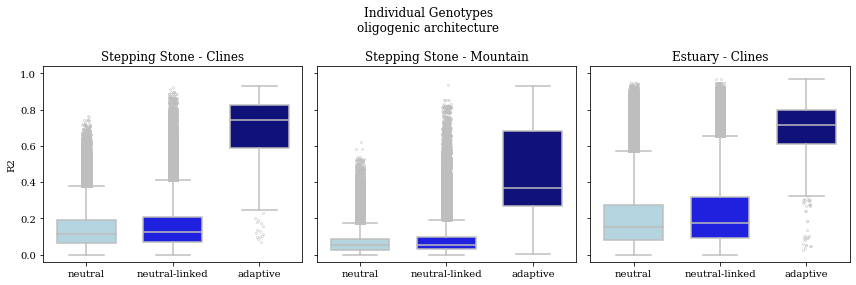

Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/05_explore_r2_geno_ind_loci/ind_mod-polygenic_marker_type_by_landscape.pdf


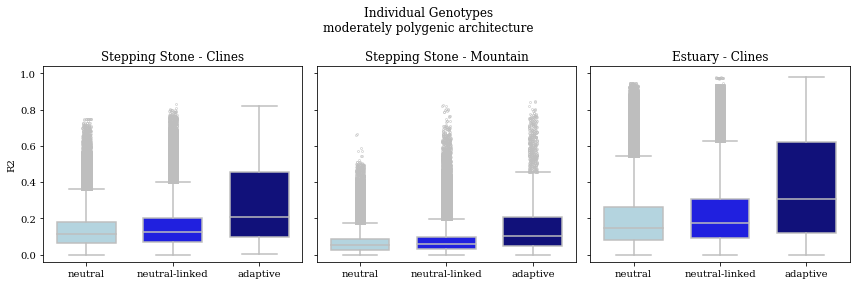

Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/05_explore_r2_geno_ind_loci/ind_highly-polygenic_marker_type_by_landscape.pdf


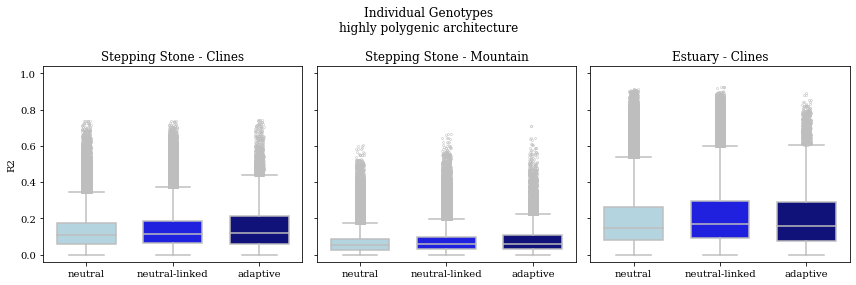

Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/05_explore_r2_geno_ind_loci/pooled_oligogenic_marker_type_by_landscape.pdf


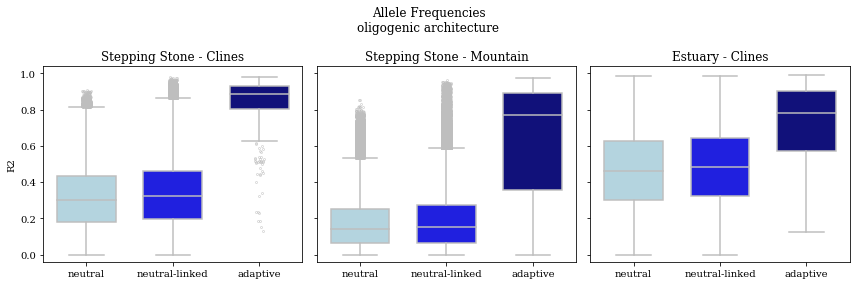

Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/05_explore_r2_geno_ind_loci/pooled_mod-polygenic_marker_type_by_landscape.pdf


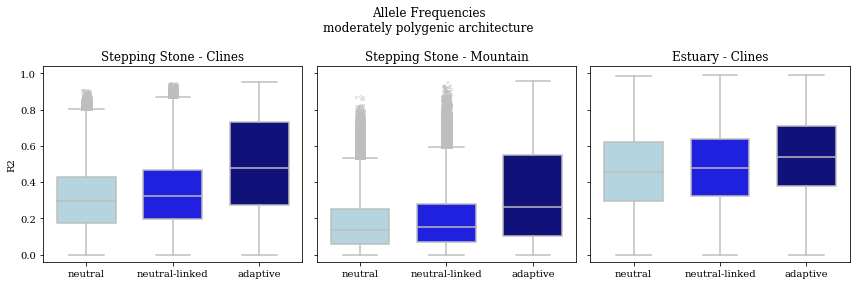

Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/05_explore_r2_geno_ind_loci/pooled_highly-polygenic_marker_type_by_landscape.pdf


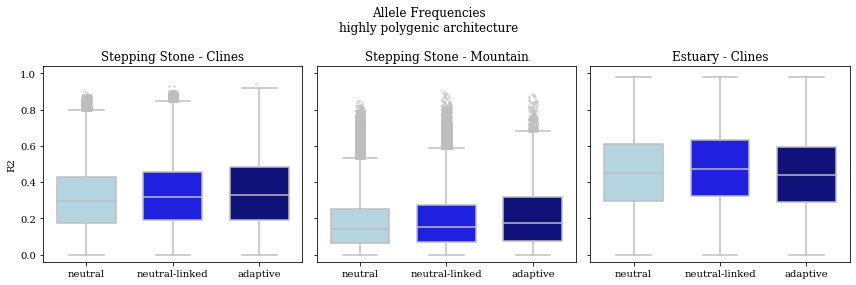

In [15]:
ldict = {
    'neutral' : 'lightblue',
    'neutral-linked' : 'blue',
    'adaptive' : 'darkblue'
}

for source in rsq_data.source.unique():
    
    for glevel in rt.hue_order['glevel']:
        fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey='row')

        for i, landscape in enumerate(rt.hue_order['landscape']):
            ax = axes[i]

            df = rsq_data[
                (rsq_data.source == source) &
                (rsq_data.glevel == glevel) &
                (rsq_data.landscape == landscape)
            ].copy()
            
            g = sns.boxplot(
                data=df,
                x='marker_type',
                y='R2',
                order=keys(ldict),
                palette=ldict,
                ax=ax,
                **boxplot_kwargs
            )
        
#             g.legend_.remove()  
            ax.set(xlabel=None, title=rt.factor_names[landscape])            
            
            title = 'Individual Genotypes' if source == 'ind' else 'Allele Frequencies'
            
#             rt.mvp.update_ticklabels(ax, replace=[('- ', '\n')])
            
            if i > 0:
                g.axes.set(ylabel=None)

        # use last iteration to up date entire fig
        g.figure.suptitle(f'{title}\n{rt.factor_names[glevel]} architecture')
        if landscape == 'SS-Clines':
            add_legend(ldict=ldict, ax=ax, bbox_to_anchor=(0.5, 1.0), ncol=3)
        ax.set_ylim(-0.04, 1.04)  # will set ylim for all subfigs using last iterated subfig
        
        mf.adjust_box_widths(list(axes), 0.85)
        mf.jitter_fliers(axes=axes)
        plt.tight_layout()
        mf.save_pdf(f'{figdir}/{source}_{glevel}_marker_type_by_landscape.pdf')
        plt.show()

<a id='fig2'></a>
### marker set x polygenicity, nested in AF or geno models

[top](#home)

Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/05_explore_r2_geno_ind_loci/ind_glevel_R2_boxplots_by_marker_type.pdf


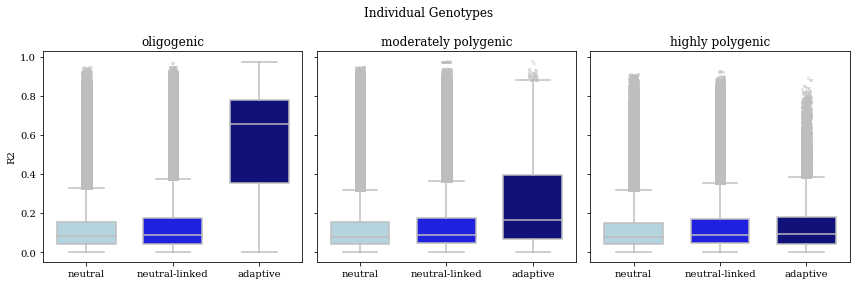

Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/05_explore_r2_geno_ind_loci/pooled_glevel_R2_boxplots_by_marker_type.pdf


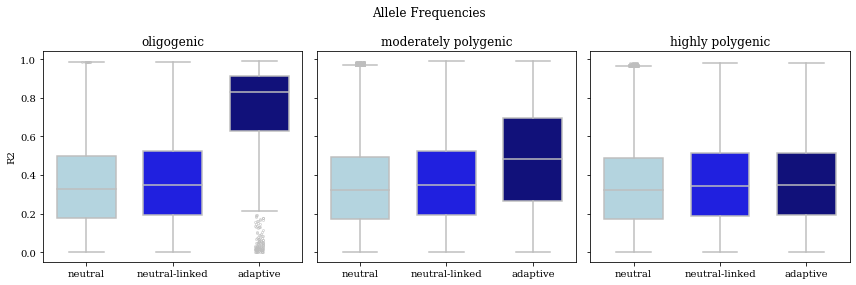

In [16]:
for source in rsq_data.source.unique():
    
    fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey='row')
    
    for i, glevel in enumerate(rt.hue_order['glevel']):
        ax = axes[i]
        
        df = rsq_data[(rsq_data.glevel == glevel) & (rsq_data.source == source)].copy()
        
        g = sns.boxplot(
            data=df,
            x='marker_type',
            y='R2',
            order=keys(ldict),
            palette=ldict,
            ax=ax,
            **boxplot_kwargs
        )
        
        g.axes.set(title=rt.factor_names[glevel], xlabel=None)
        
        if i > 0:
            g.axes.set_ylabel(None)
            
    mf.adjust_box_widths(list(axes), 0.85)
    mf.jitter_fliers(axes=axes)
    
    title = 'Individual Genotypes' if source == 'ind' else 'Allele Frequencies'
    g.figure.suptitle(title)

    plt.tight_layout()
    
    mf.save_pdf(f'{figdir}/{source}_glevel_R2_boxplots_by_marker_type.pdf')
    
    plt.show()

<a id='fig3'></a>
### marker set x landscape, nested in AF or geno models

[top](#home)

Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/05_explore_r2_geno_ind_loci/ind_landscape_R2_boxplots_by_marker_type.pdf


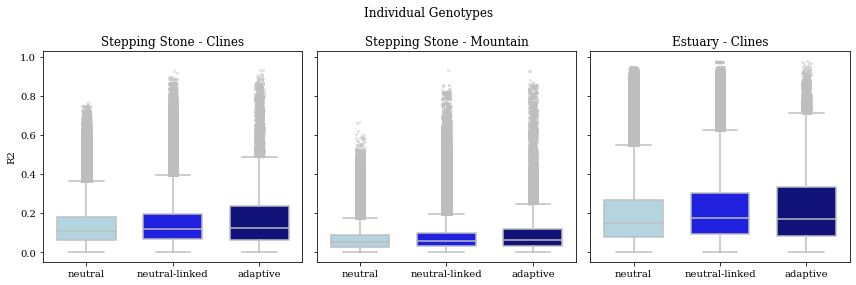

Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/05_explore_r2_geno_ind_loci/pooled_landscape_R2_boxplots_by_marker_type.pdf


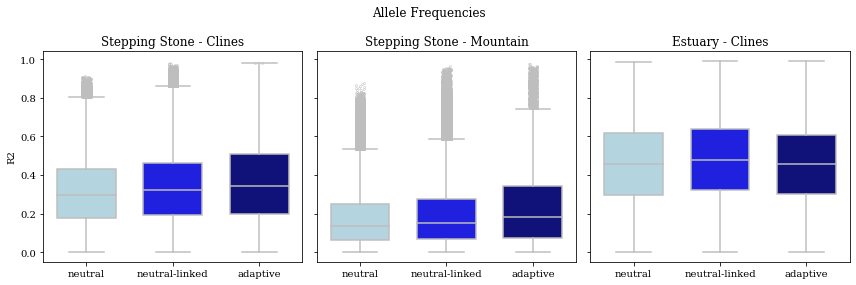

In [17]:
for source in rsq_data.source.unique():
    
    fig, axes = plt.subplots(ncols=3, figsize=(12, 4), sharey='row')
    
    for i, landscape in enumerate(rt.hue_order['landscape']):
        ax = axes[i]
        
        df = rsq_data[(rsq_data.landscape == landscape) & (rsq_data.source == source)].copy()
        
        g = sns.boxplot(
            data=df,
            x='marker_type',
            y='R2',
            order=keys(ldict),
            palette=ldict,
            ax=ax,
            **boxplot_kwargs
        )
        
        g.axes.set(title=rt.factor_names[landscape], xlabel=None)
        
        if i > 0:
            g.axes.set_ylabel(None)
            
    mf.adjust_box_widths(list(axes), 0.85)
    mf.jitter_fliers(axes=axes)
    
    title = 'Individual Genotypes' if source == 'ind' else 'Allele Frequencies'
    g.figure.suptitle(title)

    plt.tight_layout()
    
    mf.save_pdf(f'{figdir}/{source}_landscape_R2_boxplots_by_marker_type.pdf')
    
    plt.show()

<a id='fig4'></a>
### marker set x polygenicity, nested in AF or geno

[top](#home)

Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/05_explore_r2_geno_ind_loci/r2_hist_glevel_by_marker_type_ind.pdf


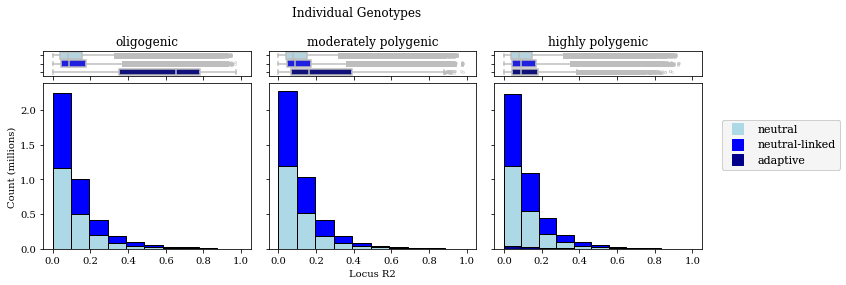

/tmp/ipykernel_206514/3243277885.py:43: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_hist.axes.set_yticklabels(labels)


Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/05_explore_r2_geno_ind_loci/r2_hist_glevel_by_marker_type_pooled.pdf


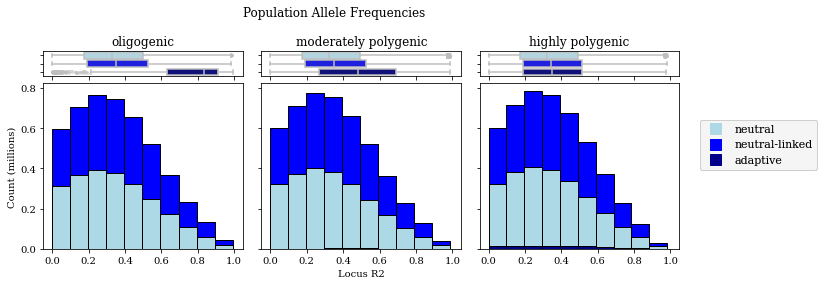

In [18]:
for source in rsq_data.source.unique():
    
    fig, axes = plt.subplots(ncols=3, figsize=(10, 4), sharey='row')
    
    ax_list = []
    for i, glevel in enumerate(rt.hue_order['glevel']):
        ax = axes[i]
        
        df = rsq_data[(rsq_data.glevel == glevel) & (rsq_data.source == source)].copy()

        ax_box, ax_hist = stacked_histo_box(
            df,
            x='R2',
            y='marker_type',
            boxplot_kws={'palette' : ldict},
            ax=ax
        )

        ax_box.axes.set_title(rt.factor_names[glevel])
        ax_box.axes.set_xlim(-0.05, 1.05)
        ax_hist.yaxis.get_offset_text().set_visible(False)

        if i == 0:
            ax_hist.set_ylabel('Count (millions)')
        if i == 1:
            ax_hist.set_xlabel('Locus R2')
        if i == 2:
            add_legend(ldict=ldict, ax=ax_hist, bbox_to_anchor=(1.0, 0.50))
        
        ax_list.append((ax_box, ax_hist))

    if source == 'ind':
        fig.suptitle('Individual Genotypes')
    else:
        fig.suptitle('Population Allele Frequencies')

    plt.tight_layout()

    fig.canvas.draw()  # needed to populate tick labels
    if source == 'pooled':
        ax_box, ax_hist = ax_list[0]
        labels = [float(text.get_text()) / 1_000_000 for text in ax_hist.axes.get_yticklabels()]
        ax_hist.axes.set_yticklabels(labels)        

    mf.save_pdf(f'{figdir}/r2_hist_glevel_by_marker_type_{source}.pdf')
    plt.show()

<a id='fig5'></a>
### marker set x landscape, nested in AF or geno

[top](#home)

Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/05_explore_r2_geno_ind_loci/r2_hist_landscape_by_marker_type_ind.pdf


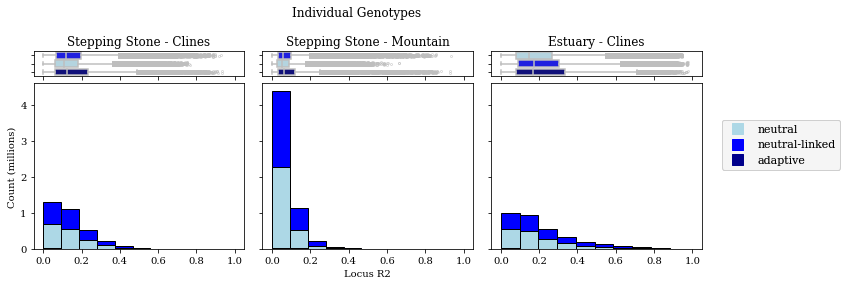

Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/05_explore_r2_geno_ind_loci/r2_hist_landscape_by_marker_type_pooled.pdf


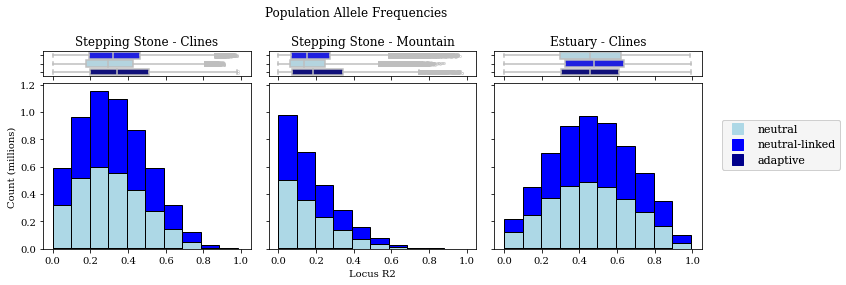

In [19]:
for source in rsq_data.source.unique():
    
    fig, axes = plt.subplots(ncols=3, figsize=(10, 4), sharey='row')
    
    ax_list = []
    for i, landscape in enumerate(rt.hue_order['landscape']):
        ax = axes[i]
#         ax = axes.flat[j]
        df = rsq_data[(rsq_data.landscape == landscape) & (rsq_data.source == source)].copy()

        ax_box, ax_hist = stacked_histo_box(
            df,
            x='R2',
            y='marker_type',
            boxplot_kws={'palette' : ldict},
            ax=ax
        )

        ax_box.axes.set_title(rt.factor_names[landscape])
        ax_box.axes.set_xlim(-0.05, 1.05)
        ax_hist.yaxis.get_offset_text().set_visible(False)

        if i == 0:
            ax_hist.set_ylabel('Count (millions)')
        if i == 1:
            ax_hist.set_xlabel('Locus R2')
        if i == 2:
            add_legend(ldict=ldict, ax=ax_hist, bbox_to_anchor=(1.0, 0.50))
        
        ax_list.append((ax_box, ax_hist))

    if source == 'ind':
        fig.suptitle('Individual Genotypes')
    else:
        fig.suptitle('Population Allele Frequencies')

    plt.tight_layout()

#     fig.canvas.draw()  # needed to populate tick labels
#     if source == 'pooled':
#         ax_box, ax_hist = ax_list[0]
#         labels = [float(text.get_text()) / 1_000_000 for text in ax_hist.axes.get_yticklabels()]
#         ax_hist.axes.set_yticklabels(labels)        

    mf.save_pdf(f'{figdir}/r2_hist_landscape_by_marker_type_{source}.pdf')
    plt.show()


<a id='fig6'></a>
### marker set x number of training loci, nested in AF or geno

[top](#home)

Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/05_explore_r2_geno_ind_loci/r2_hist_num_loci_by_marker_type_ind.pdf


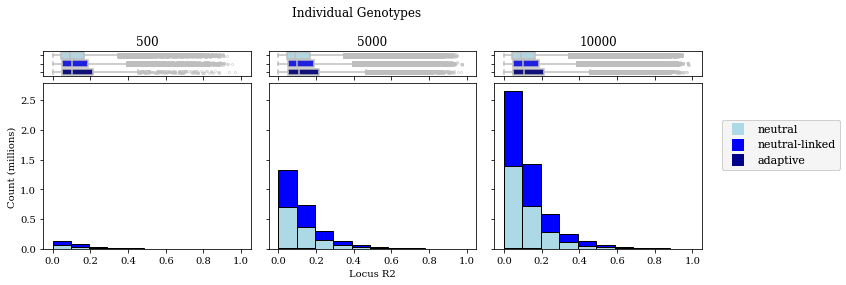

Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/05_explore_r2_geno_ind_loci/r2_hist_num_loci_by_marker_type_pooled.pdf


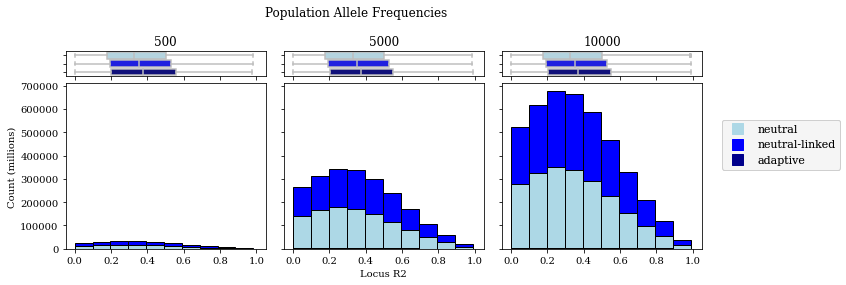

In [20]:
for source in rsq_data.source.unique():
    
    fig, axes = plt.subplots(ncols=3, figsize=(10, 4), sharey='row')
    
    ax_list = []
    for i, num_loci in enumerate(rt.hue_order['num_loci']):
        ax = axes[i]
        df = rsq_data[(rsq_data.num_loci == num_loci.zfill(5)) & (rsq_data.source == source)].copy()

        ax_box, ax_hist = stacked_histo_box(
            df,
            x='R2',
            y='marker_type',
            boxplot_kws={'palette' : ldict},
            ax=ax
        )

        ax_box.axes.set_title(rt.factor_names[num_loci])
        ax_box.axes.set_xlim(-0.05, 1.05)
        ax_hist.yaxis.get_offset_text().set_visible(False)

        if i == 0:
            ax_hist.set_ylabel('Count (millions)')
        if i == 1:
            ax_hist.set_xlabel('Locus R2')
        if i == 2:
            add_legend(ldict=ldict, ax=ax_hist, bbox_to_anchor=(1.0, 0.50))
        
        ax_list.append((ax_box, ax_hist))

    if source == 'ind':
        fig.suptitle('Individual Genotypes')
    else:
        fig.suptitle('Population Allele Frequencies')

    plt.tight_layout()

#     fig.canvas.draw()  # needed to populate tick labels
#     if source == 'pooled':
#         ax_box, ax_hist = ax_list[0]
#         labels = [float(text.get_text()) / 1_000_000 for text in ax_hist.axes.get_yticklabels()]
#         ax_hist.axes.set_yticklabels(labels)        

    mf.save_pdf(f'{figdir}/r2_hist_num_loci_by_marker_type_{source}.pdf')
    plt.show()

<a id='comp5'></a>
# compare R2 between loci specific to GF$_{geno}$ with overlap between GF$_{geno}$ and GF$_{AF}$

[top](#home)

In [21]:
# isolate ind data
ind_data = rsq_data[rsq_data.source == 'ind'].astype({'num_loci' : int}).astype({'num_loci' : str})
# ind_data['log10_r2'] = ind_data['R2'].apply(math.log10)  # not used

ind_data.head(2)

,locus,R2,source,rep,num_loci,seed,marker_type,landscape,glevel,pleio,slevel,popsize,migration,ind_unique,overlap_loci
15-718088_ind_00500_1231109,15-718088,0.106075,ind,run_20220919_0-225,500,1231109,neutral,Est-Clines,highly-polygenic,no pleiotropy,equal-S,N-cline-center-to-edge,m-constant,False,True
14-650308_ind_00500_1231109,14-650308,0.144646,ind,run_20220919_0-225,500,1231109,neutral,Est-Clines,highly-polygenic,no pleiotropy,equal-S,N-cline-center-to-edge,m-constant,False,True


<a id='nocat'></a>
### compare, no subcategories

[top](#home)

Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/05_explore_r2_geno_ind_loci/no-hue_loci_r2_comparison_ind-only_vs_overlap.pdf


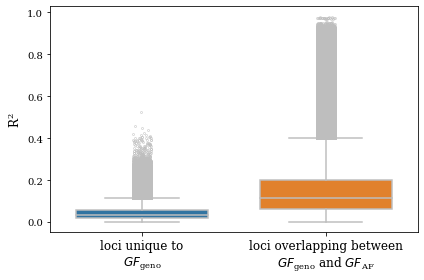

In [22]:
kwargs = rt.boxplot_kwargs.copy()  # godzilla
kwargs.pop('palette')

g = sns.boxplot(
    data=ind_data,
    y='R2',
    x='ind_unique',
    order=[True, False],
    **kwargs
)

g.axes.set_xlabel(None)
mf.jitter_fliers(axes=[g.axes])
mf.adjust_box_widths(g.axes)
g.axes.set_xticklabels(
    [
        f"loci unique to\n{rt.factor_names['geno-model']}",
        f"loci overlapping between\n{rt.factor_names['geno-model']} and {rt.factor_names['af-model']}"
    ],
    fontsize=12
)
g.axes.set_ylabel('$R^2$', fontsize=12)
plt.tight_layout()
mf.save_pdf(f'{figdir}/no-hue_loci_r2_comparison_ind-only_vs_overlap.pdf')
plt.show()

<a id='parameter'></a>
### compare by parameters

[top](#home)

In [23]:
def make_boxplots():
    # compare r2 between unique loci to `geno,ind` models to those that overlapped with `AF,pop` loci
    for hue, hue_order in rt.hue_order.items():
        if hue in ['model', 'source', 'noncausal_env', 'marker_set', 'program', 'demography', 'final_la_bin']:
            continue

        g = sns.boxplot(
            data=ind_data,
            y='R2',
            x='ind_unique',
            order=[True, False],
            hue=hue,
            hue_order=hue_order,
            **rt.boxplot_kwargs
        )

        g.axes.set_xlabel(None)
        g.axes.set_ylabel(f"{rt.factor_names['geno-model']} locus $R^{2}$", fontsize=12)
        g.legend_.remove()
        mvp.add_legend(g.figure, color_by=hue, loc='center left', bbox_to_anchor=(1, 0.55))
        mf.jitter_fliers(axes=[g.axes])
        mf.adjust_box_widths(g.axes)
        g.axes.set_xticklabels(
            [
                f"loci unique to\n{rt.factor_names['geno-model']}",
                f"loci overlapping between\n{rt.factor_names['geno-model']} and {rt.factor_names['af-model']}"
            ],
            fontsize=12
        )
        plt.tight_layout()
        mf.save_pdf(f'{figdir}/{hue}_loci_r2_comparison_ind-only_vs_overlap.pdf')
        plt.show()
        
    pass

Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/05_explore_r2_geno_ind_loci/landscape_loci_r2_comparison_ind-only_vs_overlap.pdf


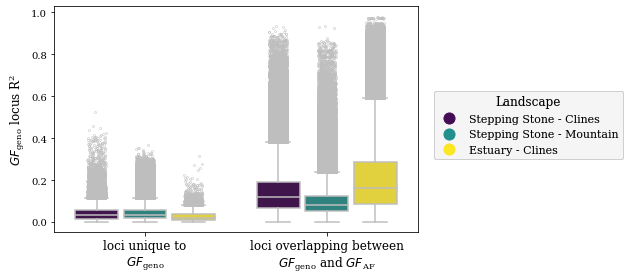

Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/05_explore_r2_geno_ind_loci/glevel_loci_r2_comparison_ind-only_vs_overlap.pdf


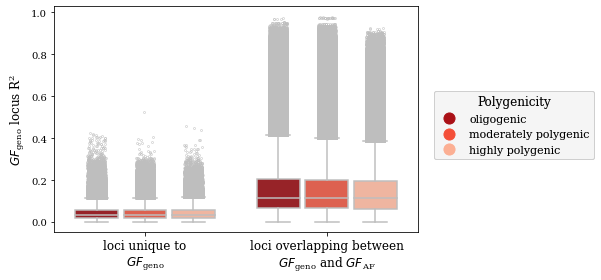

Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/05_explore_r2_geno_ind_loci/pleio_loci_r2_comparison_ind-only_vs_overlap.pdf


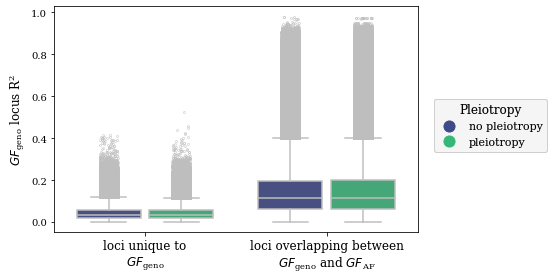

Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/05_explore_r2_geno_ind_loci/slevel_loci_r2_comparison_ind-only_vs_overlap.pdf


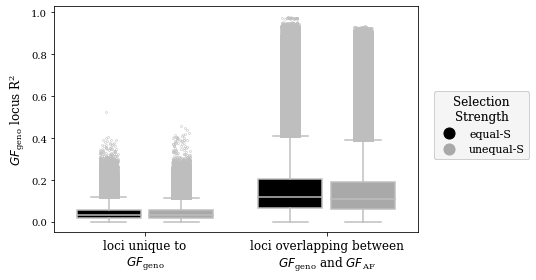

Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/05_explore_r2_geno_ind_loci/popsize_loci_r2_comparison_ind-only_vs_overlap.pdf


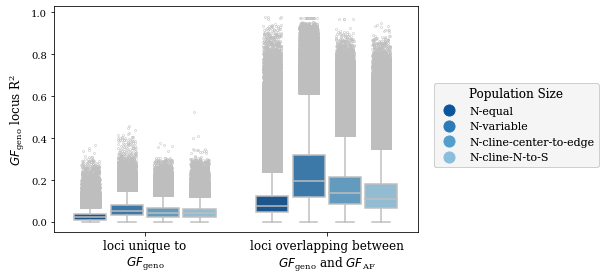

Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/05_explore_r2_geno_ind_loci/migration_loci_r2_comparison_ind-only_vs_overlap.pdf


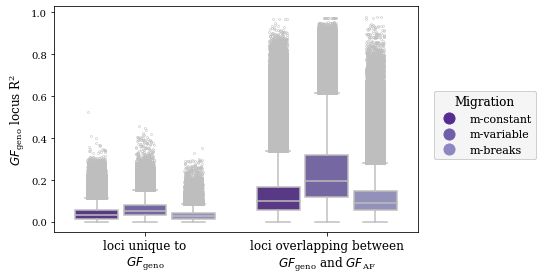

Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/05_explore_r2_geno_ind_loci/num_loci_loci_r2_comparison_ind-only_vs_overlap.pdf


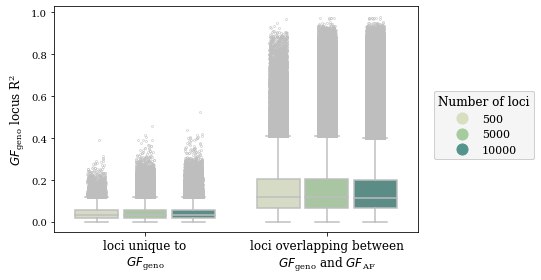

In [24]:
make_boxplots()

<a id='comp6'></a>
# for overlap loci, what is difference in R2 between workflows?

[top](#home)

In [25]:
# get loci that overlap between ind and pooled workflows
overlap_data = rsq_data[rsq_data['overlap_loci'] == True].copy()

overlap_data

,locus,R2,source,rep,num_loci,seed,marker_type,landscape,glevel,pleio,slevel,popsize,migration,ind_unique,overlap_loci
15-718088_ind_00500_1231109,15-718088,0.106075,ind,run_20220919_0-225,00500,1231109,neutral,Est-Clines,highly-polygenic,no pleiotropy,equal-S,N-cline-center-to-edge,m-constant,False,True
14-650308_ind_00500_1231109,14-650308,0.144646,ind,run_20220919_0-225,00500,1231109,neutral,Est-Clines,highly-polygenic,no pleiotropy,equal-S,N-cline-center-to-edge,m-constant,False,True
16-783804_ind_00500_1231109,16-783804,0.007530,ind,run_20220919_0-225,00500,1231109,neutral,Est-Clines,highly-polygenic,no pleiotropy,equal-S,N-cline-center-to-edge,m-constant,False,True
12-563411_ind_00500_1231109,12-563411,0.146321,ind,run_20220919_0-225,00500,1231109,neutral,Est-Clines,highly-polygenic,no pleiotropy,equal-S,N-cline-center-to-edge,m-constant,False,True
12-577296_ind_00500_1231109,12-577296,0.024588,ind,run_20220919_0-225,00500,1231109,neutral,Est-Clines,highly-polygenic,no pleiotropy,equal-S,N-cline-center-to-edge,m-constant,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9-406239_pooled_20000_1231768,9-406239,0.285057,pooled,run_20220919_450-675,20000,1231768,neutral-linked,SS-Mtn,oligogenic,pleiotropy,unequal-S,N-variable,m-variable,False,True
5-229340_pooled_20000_1231768,5-229340,0.320520,pooled,run_20220919_450-675,20000,1231768,neutral-linked,SS-Mtn,oligogenic,pleiotropy,unequal-S,N-variable,m-variable,False,True
6-259594_pooled_20000_1231768,6-259594,0.381397,pooled,run_20220919_450-675,20000,1231768,neutral-linked,SS-Mtn,oligogenic,pleiotropy,unequal-S,N-variable,m-variable,False,True
19-942766_pooled_20000_1231768,19-942766,0.004275,pooled,run_20220919_450-675,20000,1231768,neutral,SS-Mtn,oligogenic,pleiotropy,unequal-S,N-variable,m-variable,False,True


In [26]:
# double check same number of loci
overlap_data.source.value_counts()  # 9074116

ind       9074116
pooled    9074116
Name: source, dtype: int64

In [27]:
assert overlap_data.source.value_counts().unique().__len__() == 1

In [28]:
# separate into groups
ind_overlap = overlap_data[overlap_data.source == 'ind']
pooled_overlap = overlap_data[overlap_data.source == 'pooled']

In [29]:
# are indices the same?
all(ind_overlap.index == pooled_overlap.index.str.replace('pooled', 'ind'))

True

In [30]:
# create a dataframe for figure
diff_data = pd.DataFrame(
    {
        'diffs' : pooled_overlap.reset_index()['R2'] - ind_overlap.reset_index()['R2'],
        'percs' :  ind_overlap.reset_index()['R2'] / pooled_overlap.reset_index()['R2'],
        'landscape' : pooled_overlap.landscape.tolist(),
    }
)

diff_data['log10(perc)'] = [math.log10(x) for x in diff_data['percs']]

diff_data.head()

,diffs,percs,landscape,log10(perc)
0,0.205140,0.340842,Est-Clines,-0.467447
1,0.357623,0.287985,Est-Clines,-0.540630
2,0.288276,0.025456,Est-Clines,-1.594213
3,0.377184,0.279503,Est-Clines,-0.553614
4,0.197276,0.110825,Est-Clines,-0.955363


Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/05_explore_r2_geno_ind_loci/af-pop-R2_minus_geno-ind-R2_overlap_histoboxes.pdf


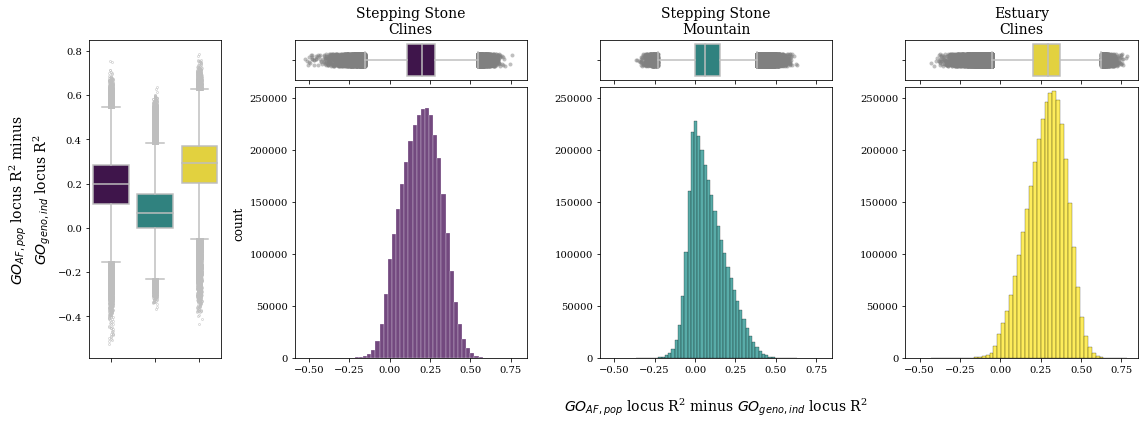

In [31]:
# make a figure

fig, axes = plt.subplots(ncols=4, figsize=(16, 6), gridspec_kw={"width_ratios": (0.16, 0.28, 0.28, 0.28)})

# MAKE A BOXPLOT
g = sns.boxplot(
    data=diff_data,
    x='landscape', 
    y='diffs',
    ax=axes[0],
    order=mvp.hue_order['landscape'],
    **rt.boxplot_kwargs
)

mf.jitter_fliers(axes=[g.axes])

g.axes.set_ylabel(
    f'{rt.factor_names["pooled"]} locus R$^2$ minus\n{rt.factor_names["ind"]} locus R$^2$',
    fontsize=14
)

g.axes.set_xlabel(None)

g.axes.set_xticklabels([None, None, None])

# CREATE HISTOGRAMS
kwargs = mvp.boxplot_kwargs.copy()
palette = kwargs.pop('palette')
for ax, landscape in zip(axes[1:], mvp.hue_order['landscape']):
    ax_box, ax_hist = mf.histo_box(
        diff_data[diff_data.landscape==landscape]['diffs'],
        histbins=50,
        ax=ax,
        histplot_kws=dict(
            color=mvp.boxplot_kwargs['palette'][landscape],
            edgecolor='k' if landscape != 'SS-Clines' else 'white',
            linewidth=0.25
        ),
        boxplot_kws={'color' : palette[landscape], **kwargs}
    )
    ax_box.set_title(mvp.factor_names[landscape].replace(' - ', '\n'), fontsize=14)
    
    ax_hist.set_ylim(0, 260100)
    ax_hist.set_xlim(axes[0].get_ylim())
    
    if landscape == 'SS-Clines':
        ax_hist.set_ylabel('count', fontsize=12, y=0.5)
    
    if landscape == 'SS-Mtn':
        ax.set_xlabel(f'\n{rt.factor_names["pooled"]} locus R$^2$ minus {rt.factor_names["ind"]} locus R$^2$',
                      fontsize=14)
    
plt.tight_layout()

mf.save_pdf(f'{figdir}/af-pop-R2_minus_geno-ind-R2_overlap_histoboxes.pdf')

In [33]:
plt.rcParams.update({'mathtext.default': 'regular'})

pearson =  0.773995034392473
Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/05_explore_r2_geno_ind_loci/SS-Clines_scatter.pdf


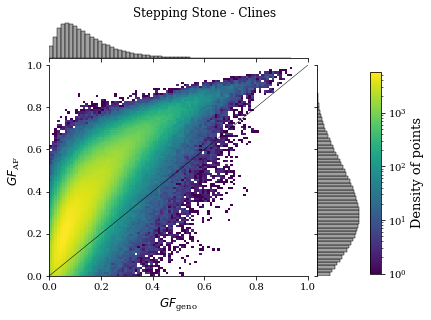

pearson =  0.7045862897498618
Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/05_explore_r2_geno_ind_loci/SS-Mtn_scatter.pdf


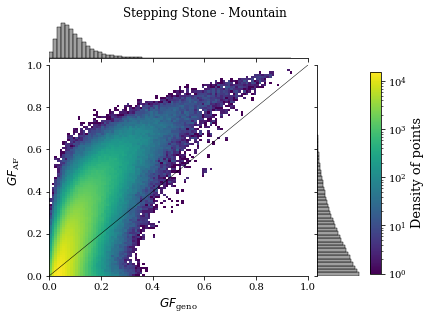

pearson =  0.8287759936355975
Saved to:  /work/lotterhos/brandon/runtime/figures/05_supplemental/05_explore_r2_geno_ind_loci/Est-Clines_scatter.pdf


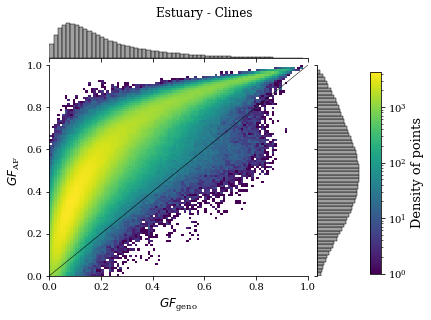

In [34]:
for landscape in mvp.hue_order['landscape']:
    x = ind_overlap[ind_overlap.landscape == landscape]['R2']
    y = pooled_overlap[pooled_overlap.landscape == landscape]['R2']
    y.index = y.index.str.replace('pooled', 'ind')
    
    print('pearson = ', x.corr(y, method='pearson'))
    
    g = mf.scatter2d(
        x=x,
        y=y,
        title=mvp.factor_names[landscape],
        xlab=rt.factor_names['geno-model'],
        ylab=rt.factor_names['af-model'],
        cmap='viridis',
        marginal_kws={'color' : 'gray'},
        xlim=(0, 1),
        ylim=(0, 1)
    )
    
    mf.draw_xy(g.ax_joint)
    
    mf.save_pdf(f'{figdir}/{landscape}_scatter.pdf')
    
    plt.show()

In [36]:
formatclock(dt.now() - t0)

'0-00:15:51'